In [278]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.cluster import KMeans

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, plot_metric

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

random_state = 2025

In [279]:
# 데이터 불러오기
# 리더보드에서 높은 성적을 기록했던 다음 코드를 참고하였습니다.
# https://www.kaggle.com/code/tmheo74/11th-solution-public-98316-private-99336

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [280]:
# 데이터 살펴보기
display(train.shape)
display(test.shape)
display(sample_submission.shape)
display(train.info())

(15035, 21)

(6468, 20)

(6468, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

None

In [281]:
# 이상치 제거
train = train[~((train['sqft_living'] > 12000) & (train['price'] < 3000000))].reset_index(drop=True)

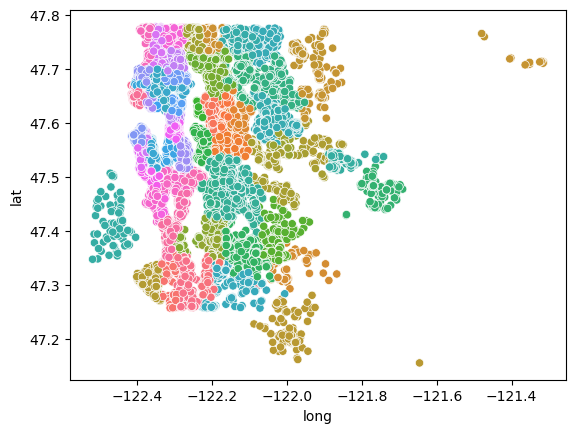

In [282]:
# 데이터 전처리

X = train.drop(['id', 'price'], axis=1)
y = train['price']
y = np.log1p(y)

X_test = test.drop(['id'], axis=1)

def preprocessing(data):
  data.drop('date', axis=1, inplace=True)
  data['zipcode'] = data['zipcode'].astype(str)
  # zipcode의 첫 두 숫자는 98로 고정
  # 나머지는 one-hot encoding
  data['zipcode-3'] = 'z_' + data['zipcode'].str[2:3]
  data['zipcode-4'] = 'z_' + data['zipcode'].str[3:4]
  data['zipcode-5'] = 'z_' + data['zipcode'].str[4:5]
  data['zipcode-34'] = 'z_' + data['zipcode'].str[2:4]
  data['zipcode-45'] = 'z_' + data['zipcode'].str[3:5]
  data['zipcode-35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]
  data['zipcode'] = 'z_' + data['zipcode']
  sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(data['zipcode'].unique()), data=data,legend=False);

  # 위도, 경도 데이터를 2차원으로 PCA Transform을 수행하여
  # 새로운 feature를 생성
  coord = data[['lat','long']]
  pca = PCA(n_components=2)
  pca.fit(coord)

  coord_pca = pca.transform(coord)

  data['coord_pca1'] = coord_pca[:, 0]
  data['coord_pca2'] = coord_pca[:, 1]

  # kmeans for lat, long
  # 위도, 경도 데이터에 K-Means clustering을 적용하여 zipcode와 유사한 개념의 feature 생성
  # K 값은 rmse값이 가장 작았을 때의 값인 32 사용.
  kmeans = KMeans(n_clusters=32, random_state=random_state).fit(coord)
  coord_cluster = kmeans.predict(coord)
  data['coord_cluster'] = coord_cluster
  data['coord_cluster'] = data['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))

  cat_cols = data.select_dtypes('object').columns
  for col in cat_cols:
    ohe_df = pd.get_dummies(data[[col]], prefix='ohe_'+col)
    data.drop(col, axis=1, inplace=True)
    data = pd.concat([data, ohe_df], axis=1)

  return data
X = preprocessing(X)

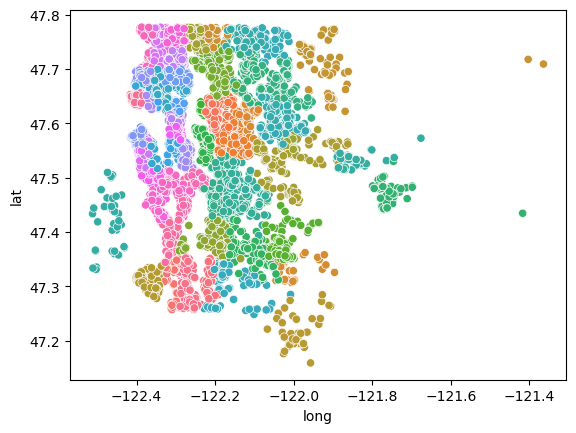

In [283]:
X_test = preprocessing(X_test)

In [284]:
X.columns.values

array(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'coord_pca1', 'coord_pca2',
       'ohe_zipcode_z_98001', 'ohe_zipcode_z_98002',
       'ohe_zipcode_z_98003', 'ohe_zipcode_z_98004',
       'ohe_zipcode_z_98005', 'ohe_zipcode_z_98006',
       'ohe_zipcode_z_98007', 'ohe_zipcode_z_98008',
       'ohe_zipcode_z_98010', 'ohe_zipcode_z_98011',
       'ohe_zipcode_z_98014', 'ohe_zipcode_z_98019',
       'ohe_zipcode_z_98022', 'ohe_zipcode_z_98023',
       'ohe_zipcode_z_98024', 'ohe_zipcode_z_98027',
       'ohe_zipcode_z_98028', 'ohe_zipcode_z_98029',
       'ohe_zipcode_z_98030', 'ohe_zipcode_z_98031',
       'ohe_zipcode_z_98032', 'ohe_zipcode_z_98033',
       'ohe_zipcode_z_98034', 'ohe_zipcode_z_98038',
       'ohe_zipcode_z_98039', 'ohe_zipcode_z_98040',
       'ohe_zipcode_z_98042', 'ohe_zipcode_z

In [285]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [286]:
import lightgbm as lgb
# 좋은 성적을 기록했던 파라메터 선정. 5중 Kfold를 수행
# 10000번 iter를 돌려 최적의 iter에서의 모델 선택.
lgb_meta_param = {'num_leaves': 15,
         'objective':'regression',
         'max_depth': 5,
         'learning_rate': 0.015,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

X_train, y_train = X, y
folds = KFold(n_splits=5, shuffle=True, random_state=random_state)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

verbose_eval = True
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    if verbose_eval > 0: print(f'Fold : {fold_ + 1}')
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(lgb_meta_param, trn_data, num_round, valid_sets=[trn_data, val_data])#, early_stopping_rounds=200)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

    cv_fold_score = rmse(y_train.iloc[val_idx], oof[val_idx])

    if verbose_eval > 0: print(f'Fold {fold_ + 1} / CV-Score: {cv_fold_score:.6f}')

    fold_importance_df = pd.DataFrame()
    fold_importance_df['feature'] = X_train.columns.tolist()
    fold_importance_df['importance'] = clf.feature_importance('gain')
    fold_importance_df['fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

cv_score = rmse(y_train, oof)
print(f'CV-Score: {cv_score:.6f}')

Fold : 1
Fold 1 / CV-Score: 129835.830686
Fold : 2
Fold 2 / CV-Score: 103340.323785
Fold : 3
Fold 3 / CV-Score: 110515.145211
Fold : 4
Fold 4 / CV-Score: 103034.889855
Fold : 5
Fold 5 / CV-Score: 131357.075574
CV-Score: 116292.555155


In [287]:
submission = pd.DataFrame({'id': test['id'], 'price': np.expm1(predictions)})
submission.to_csv('submission.csv', index=False)

In [288]:
# 최종 결과물 이외의 시도들
# 1. 내 방식대로의 데이터 전처리
"""
X_test = test.drop(['date','id'], axis=1)
X_test['zipcode'] = X_test['zipcode'].astype(str)

cat_cols = X_test.select_dtypes('object').columns
for col in cat_cols:
  ohe_df = pd.get_dummies(X_test[[col]], prefix='ohe_'+col)
  X_test.drop(col, axis=1, inplace=True)
  X_test = pd.concat([X_test, ohe_df], axis=1)

for c in skew_columns:
    X_test[c] = np.log1p(X_test[c].values)

for c in skew_columns2:
    X_test[c] = np.power(X_test[c].values, 1/3)

# date에는 년도만
X_test['date'] = X_test['date'].apply(lambda x:x[:4]).astype(int)
# old : date-지어진년도 또는 date-새로지은년도
X_test['old'] = X_test.apply(lambda x: x['date'] - (x['yr_built'] if x['yr_renovated'] == 0 else x['yr_renovated']), axis=1)
X_test = X_test.drop('yr_built', axis=1)
# 새로지은년도는 0(없음) 1(있음) 이분화
X_test['yr_renovated'] = X_test['yr_renovated'].apply(lambda x: x if x==0 else 1)

# date, 위도, 경도, 이산형 데이터는 minmax로 normalization
minmax_list = ['date', 'bedrooms', 'bathrooms', 'lat', 'long', 'floors', 'view', 'condition', 'grade', 'old']
X_test[minmax_list] = minmax.transform(X_test[minmax_list])

# 연속형 데이터는 Standardization
standard_list = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
X_test[standard_list] = standard.transform(X_test[standard_list])

display(X_test.head())"""

"\nX_test = test.drop(['date','id'], axis=1)\nX_test['zipcode'] = X_test['zipcode'].astype(str)\n\ncat_cols = X_test.select_dtypes('object').columns\nfor col in cat_cols:\n  ohe_df = pd.get_dummies(X_test[[col]], prefix='ohe_'+col)\n  X_test.drop(col, axis=1, inplace=True)\n  X_test = pd.concat([X_test, ohe_df], axis=1)\n\nfor c in skew_columns:\n    X_test[c] = np.log1p(X_test[c].values)\n\nfor c in skew_columns2:\n    X_test[c] = np.power(X_test[c].values, 1/3)\n\n# date에는 년도만\nX_test['date'] = X_test['date'].apply(lambda x:x[:4]).astype(int)\n# old : date-지어진년도 또는 date-새로지은년도\nX_test['old'] = X_test.apply(lambda x: x['date'] - (x['yr_built'] if x['yr_renovated'] == 0 else x['yr_renovated']), axis=1)\nX_test = X_test.drop('yr_built', axis=1)\n# 새로지은년도는 0(없음) 1(있음) 이분화\nX_test['yr_renovated'] = X_test['yr_renovated'].apply(lambda x: x if x==0 else 1)\n\n# date, 위도, 경도, 이산형 데이터는 minmax로 normalization\nminmax_list = ['date', 'bedrooms', 'bathrooms', 'lat', 'long', 'floors', 'view', 'con

In [289]:
# 2. 기존 모델 앙상블
# gboost, xgboost, lightgbm, rdforest 4개 모델의 평균 값을 사용한 회귀 앙상블 모델을 만들어 보았음.
"""
# 4개의 회귀 모델 사용.
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# 각 모델의 일반적인 성능 체크
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df"""
"""lgb_param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'num_iterations': [1000],
}
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'eval_metric': [rmse]
}

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    model, name = model['model'], model['name']

    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=3, verbose=verbose, n_jobs=n_jobs)
    # 모델 fitting
    if name=='XGBoost':
      grid_model.fit(train, y)
    else:
      grid_model.fit(train, y, eval_metric=rmse)
    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results"""
"""def AveragingBlending(models, x, y, sub_x):
    for m in models :
        m['model'].fit(x.values, y)

    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)"""

"def AveragingBlending(models, x, y, sub_x):\n    for m in models :\n        m['model'].fit(x.values, y)\n\n    predictions = np.column_stack([\n        m['model'].predict(sub_x.values) for m in models\n    ])\n    return np.mean(predictions, axis=1)"

## Result
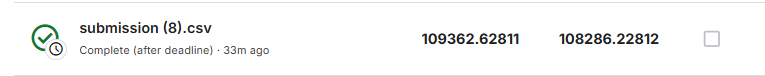